In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [6]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [7]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Modelling - Train, test split

In [8]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

# XGBOOST

In [9]:
from xgboost import XGBRegressor


In [10]:
from pandas import concat


In [11]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [12]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [13]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(trainX, trainy,verbose = True)
 # make a one-step prediction
 yhat = model.predict(asarray([testX]))
 return yhat[0]

## Walk-forward validation using XGBoost

Retraining model on updated training data, appended at every step to add the new value from test set.

In [14]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = xgboost_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)

    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy

In [15]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)

In [16]:
import pandas as pd


In [17]:
# transform the time series data into supervised learning
data2 = series_to_supervised(X, n_in=4)

In [18]:
from sklearn.metrics import mean_squared_error


>expected=7.5, predicted=15.1
>expected=7.8, predicted=9.0
>expected=3.5, predicted=6.0
>expected=3.9, predicted=6.1
>expected=6.8, predicted=7.1
>expected=2.1, predicted=4.7
MAE: 2.751
ME: 2.751
RMSE: 3.603
Direction Accuracy: 0.800


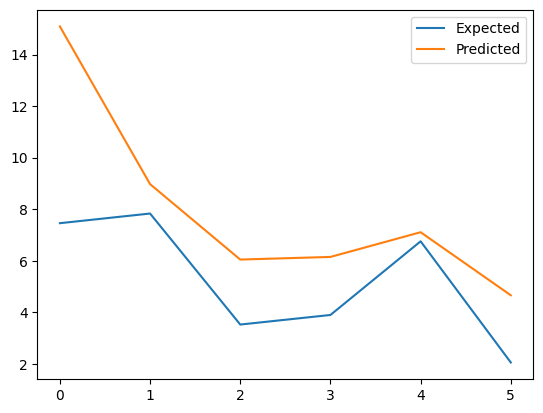

In [19]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = walk_forward_validation(data2, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

The metrics are poorer than Static ARIMA but directino accuracy is similar.

## Rolling forecast with XGBoost  

The intention was to explore using the XGBoost model to forecast for the 6 "steps" in test set without retraining and evaluate. But there may not be such a thing as static forecasting for XGBoost as the model takes an input which is a 4-day lag here and predicts the next step. To predict the subsequent steps the window has to be moved for input. 

Which means for XGBoost, there is just rolling or walk-forward validation.

In [20]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)

In [21]:
# transform the time series data into supervised learning
data = series_to_supervised(X, n_in=4)

In [22]:
train, test = train_test_split(data, 6)


In [23]:
train = asarray(train)

In [24]:
testX, testy = test[0, :-1], test[0, -1]

In [25]:
# Training XGBoost on entire training data once.

train, test = train_test_split(data, 6)

train = asarray(train)
 # split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
static = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
static_model = static.fit(trainX, trainy)


In [26]:
# make a one-step prediction
yhat = static_model.predict(asarray([testX]))
yhat[0]

15.090609

In [27]:
testX2, testy2 = test[1, :-1], test[1, -1]


In [28]:
yhat2 = static_model.predict(asarray([testX2]))
yhat2[0]

5.584712

In [29]:
predictions = list()
direction_accuracies = list() 
for i in range(len(test)):
# split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
# fit model on history and make a prediction
    yhat = static_model.predict(asarray([testX]))
# store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

>expected=7.5, predicted=15.1
>expected=7.8, predicted=5.6
>expected=3.5, predicted=4.8
>expected=3.9, predicted=5.8
>expected=6.8, predicted=4.3
>expected=2.1, predicted=2.8


In [30]:
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

MAE: 2.751
ME: 1.139
RMSE: 3.529
Direction Accuracy: 0.600


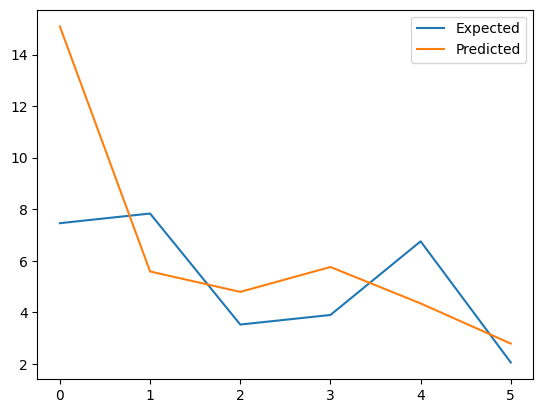

In [31]:
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

Here the ME is less but RMSE is higher. And Direction Accuracy is lower.

### Rolling window forecast for XGBoost

In [165]:

predictions = list()
direction_accuracies = list() 
# step over each time-step in the test set
for i in range(len(test)):
# split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = static_model.predict(asarray([testX]))
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
error = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy

>expected=7.5, predicted=15.1
>expected=7.8, predicted=5.6
>expected=3.5, predicted=4.8
>expected=3.9, predicted=5.8
>expected=6.8, predicted=4.3
>expected=2.1, predicted=2.8


In [166]:
error = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

MAE: 2.692
ME: 1.139
RMSE: 3.529
Direction Accuracy: 0.600


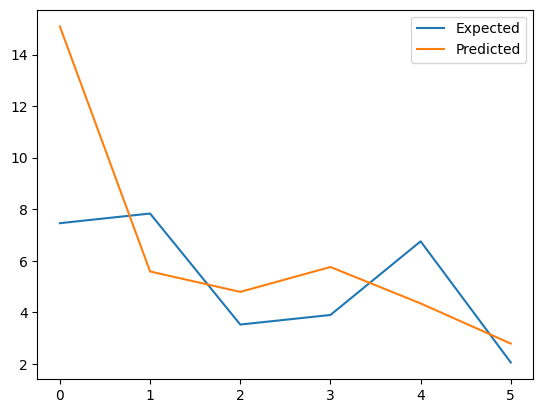

In [167]:
print('MAE: %.3f' % error)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()